In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

# Import dataset

In [2]:
dataFrame = pd.read_table(r"./Data/FDAXM22-EUREX 5Min.csv", sep = ";", engine = 'python')
for col in dataFrame.columns:
    if col[0] == " ":
        dataFrame = dataFrame.rename(columns={col : col[1:]})

In [3]:
dataFrame_morning = pd.read_table("Data/dataIB.csv", sep = ";", engine = 'python')

In [4]:
dataFrame_daily = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')

In [5]:
dataFrame_norm = pd.read_table("Data/dataNormalisee5Min.csv", sep = ";", engine = 'python')

In [6]:
dataFrame_norm_daily = pd.read_table("Data/dataNormalisee.csv", sep = ";", engine = 'python')

In [7]:
dataFrame_norm_IB = pd.read_table("Data/dataIBNormalisee.csv", sep = ";", engine = 'python')

# Statistics

In [8]:
df = dataFrame

In [66]:
df_norm = dataFrame_norm

In [9]:
df.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Last', 'Volume', '# of Trades',
       'Bid Volume', 'Ask Volume', 'etat variable 'Volume'',
       'etat variable 'DeltaSpread'', 'etat variable 'PriceChange'',
       'etat variable 'Delta'', 'deltaSpread', 'priceChange', 'delta',
       'etat variable 'spread'', 'etat variable 'open'',
       'etat variable 'close'', 'etat variable 'deltaOpen'',
       'etat variable 'deltaClose'', 'currentHigh - barClose',
       'barClose - currentLow', 'nb of Higher mmPrix', 'nb of Lower mmPrix',
       'nb of Grey mmPrix', 'etatBarCloseToDailyCurrentVA'',
       'etatBarPOCToBar''],
      dtype='object')

In [11]:
import matplotlib.pyplot as plt
lengths = { column : len(set(df[column])) for column in df.columns }
for column, l in sorted(lengths.items(), key=lambda x : x[1]):
  #if 'Date' not in column and 'Time' not in column:
  #if 'zscore' in column and 'barOpen' not in column and 'current' not in column:
  if "Volume" == column:
    print("{} -> {}".format(column, l))
    p = 0.25
    if 'zscore' in column and 'barOpen' not in column and 'current' not in column:
        df[column].hist(bins=int(p * l), figsize=(40,10))
    else:
        df[column].hist(bins=int(p * l), figsize=(40,15))
    # Limit the width
    column_numpy = np.sort(df[column].values)
    plt.xlim(column_numpy[int(0.01*column_numpy.shape[0])] - (np.std(column_numpy) / 4), column_numpy[int(0.99*column_numpy.shape[0])] + (np.std(column_numpy) / 4))
    # Limit the height
    if 'zscore' in column and 'barOpen' not in column and 'current' not in column:
        plt.ylim(0, 25)
    else:
        np_hist = np.histogram(column_numpy, bins=int(p * l))[0]
        plt.ylim(0, np.max(np_hist) * 1.05)
    plt.xlabel("{} value".format(column))
    plt.ylabel("Number of candels")
    plt.title("Histogram of {} ({} distinct values)".format(column, l))
    plt.show()

<AxesSubplot:>

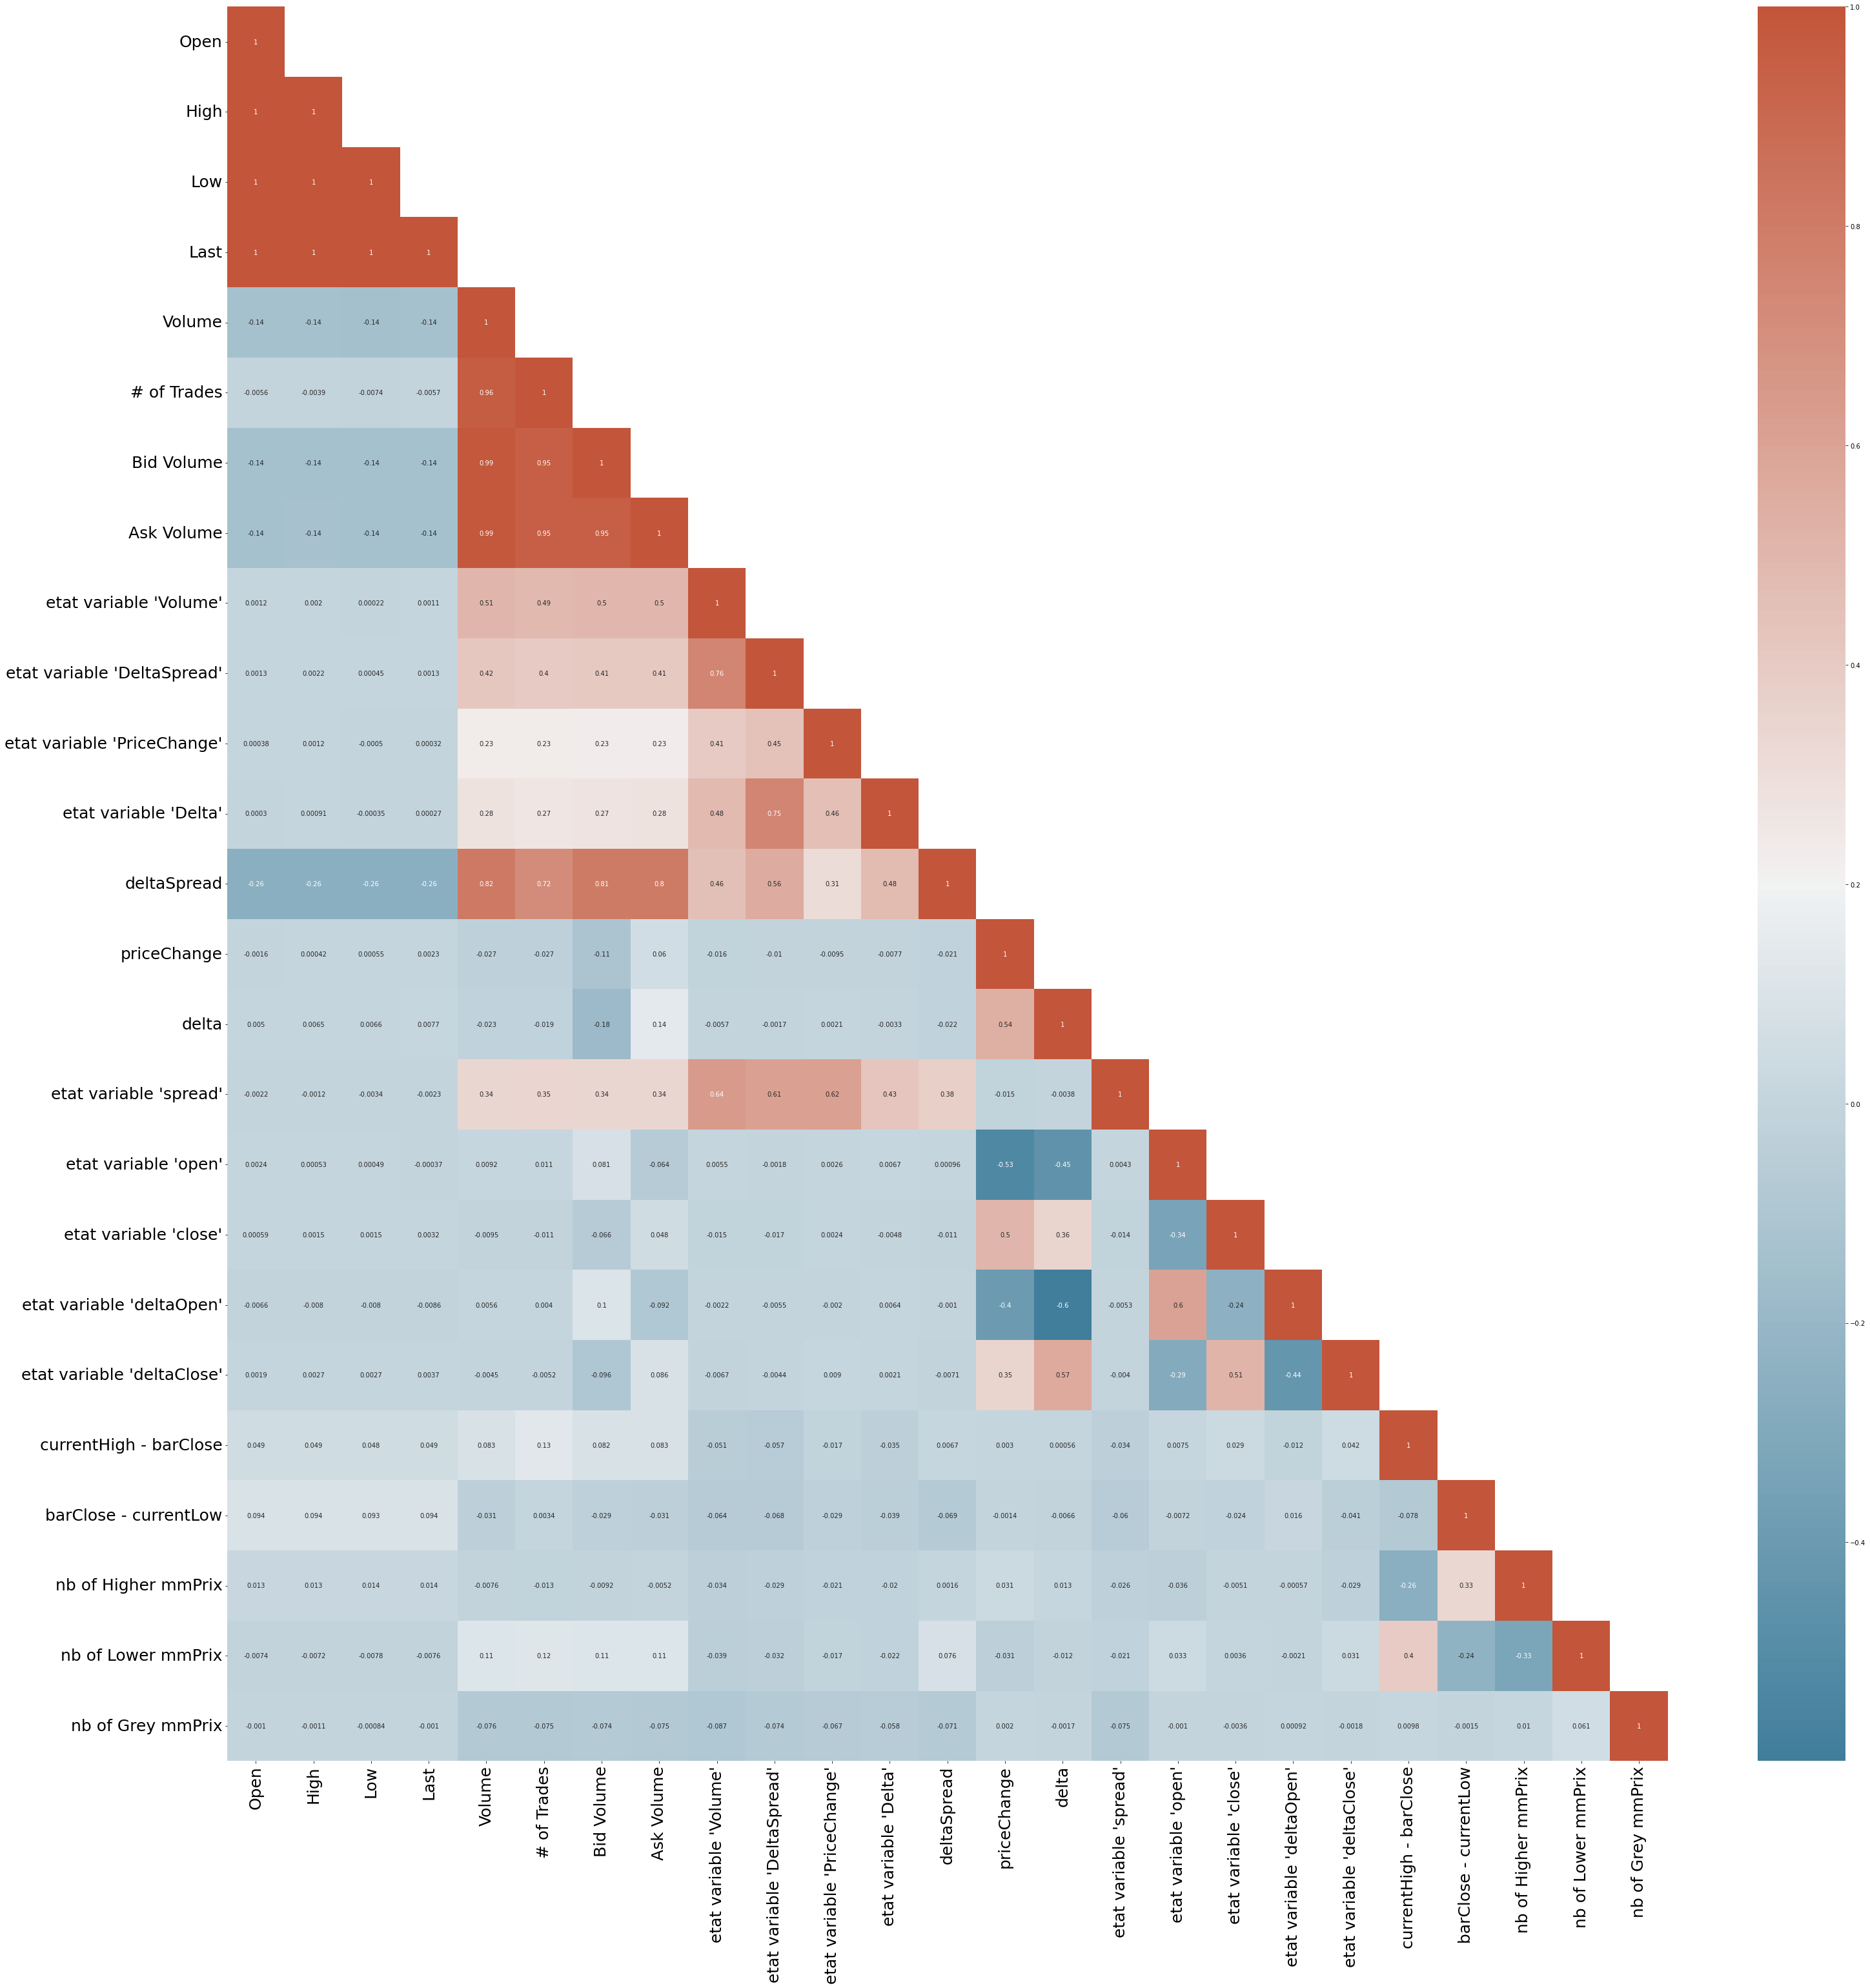

In [10]:
import seaborn as sns
plt.figure(figsize=(50,50))

df_without_NAN = df.drop("etatBarCloseToDailyCurrentVA'", axis = 1)
df_without_NAN = df_without_NAN.drop("etatBarPOCToBar'", axis=1)
corr = df_without_NAN.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
for i in range(len(mask)):
    mask[i][i] = False
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = plt.gca()
ax.tick_params(labelsize=25)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# Feature Importance with XGB

In [31]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

In [ ]:
df = dataFrame

In [12]:
data_columns = [x for x in df.columns if 'Time' not in x and 'Date' not in x]
for i in range(len(data_columns)):
    if data_columns[i][0] == " " : data_columns[i] = data_columns[i][1:]

In [22]:
def make_XGB_dataset(df, data_columns):
    X = []
    y = []
    a = df[data_columns].values
    b = df['Last'].values
    classif = lambda x : 0 if x <= 0 else 1
    for i in range(df.shape[0]-1):
        X.append(a[i])
        y.append(classif(b[i+1]-b[i]))
    return np.array(X), np.array(y).reshape(-1,1)

In [23]:
def train_xgb(df, data_columns):
    X, y = make_XGB_dataset(df, data_columns)
    model = xgb.XGBClassifier()
    model.fit(X, y)
    return model

In [27]:
def plot_feature_imp(model, data_columns):
    plt.figure(figsize=(30,50))
    imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
    features = pd.DataFrame(data_columns, columns=['Features'])
    feature_imp = pd.concat([features,imp_score], axis=1)
    feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
    sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
    plt.show()
    return feature_imp

In [28]:
model = train_xgb(df, data_columns)

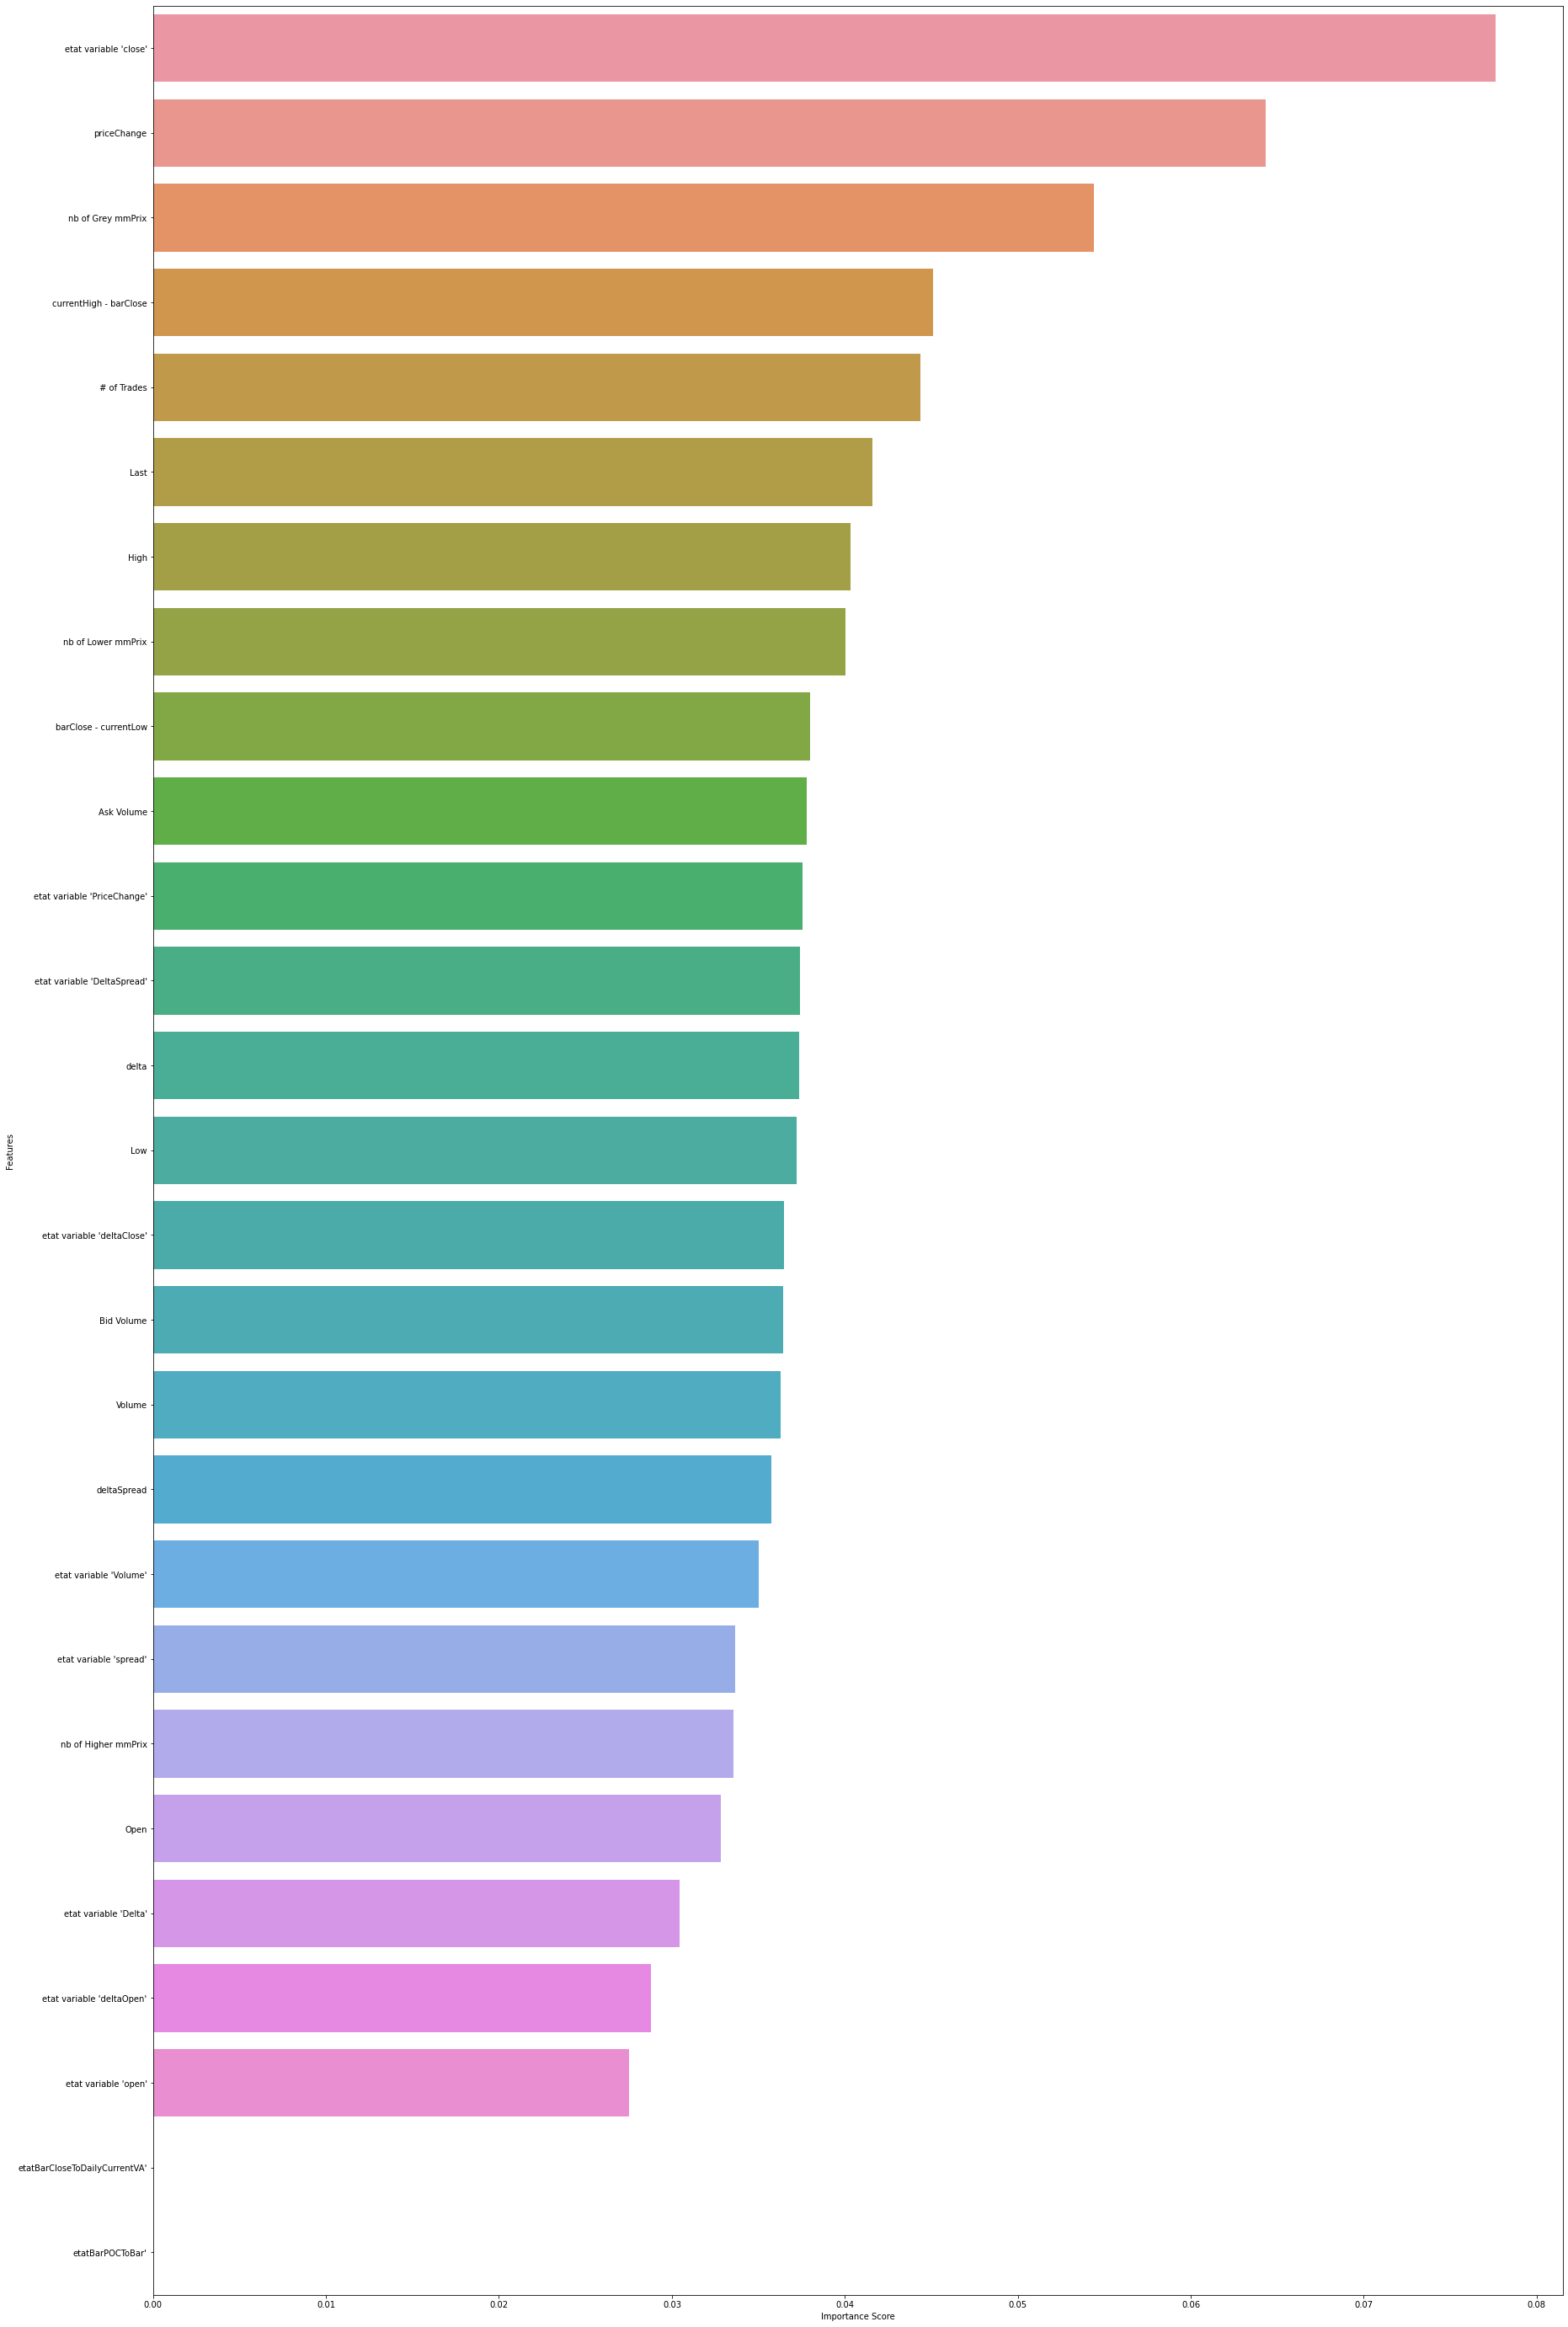

In [29]:
feature_imp = plot_feature_imp(model, data_columns)

In [30]:
list(feature_imp['Features'])[:15]

["etat variable 'close'",
 'priceChange',
 'nb of Grey mmPrix',
 'currentHigh - barClose',
 '# of Trades',
 'Last',
 'High',
 'nb of Lower mmPrix',
 'barClose - currentLow',
 'Ask Volume',
 "etat variable 'PriceChange'",
 "etat variable 'DeltaSpread'",
 'delta',
 'Low',
 "etat variable 'deltaClose'"]

# PCA

In [33]:
# Libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [34]:
df = dataFrame

In [35]:
data_columns = [x for x in df.columns if 'Time' not in x and 'Date' not in x]
for i in range(len(data_columns)):
    if data_columns[i][0] == " " : data_columns[i] = data_columns[i][1:]

In [65]:
# Perform PCA
def train_pca(dataF, dataF_norm, data_columns, norm):
    # Get columns
    if norm:
        df = dataF_norm
    else:
        df = dataF
    X = df[data_columns].values
    '''
    # Norm
    if norm:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    '''
    # Fit the PCA without arguments
    pca_without_args = PCA()
    X_pca_without_args = pca_without_args.fit(X)
    # Fit PCA with 0.99 target
    pca_with_args = PCA(0.99)
    X_pca_with_args = pca_with_args.fit(X)
    # Return everything
    return pca_without_args, X_pca_without_args, pca_with_args, X_pca_with_args

In [67]:
pca_without_args_normed, X_pca_without_args_normed, pca_with_args_normed, X_pca_with_args_normed = train_pca(df, df_norm, data_columns, norm=True)
pca_without_args, X_pca_without_args, pca_with_args, X_pca_with_args = train_pca(df, df_norm, data_columns, norm=False)

In [92]:
pca_without_args.n_components_

27

In [68]:
import os
from joblib import dump, load
try:
    os.mkdir("ACP")
except:
    print("Dossier ACP existe déjà")

Dossier ACP existe déjà


In [69]:
dump(pca_without_args_normed, "ACP/pca_without_args_normed.joblib")
dump(pca_with_args_normed, "ACP/pca_with_args_normed.joblib")
dump(pca_without_args, "ACP/pca_without_args.joblib")
dump(pca_with_args, "ACP/pca_with_args.joblib")

['ACP/pca_with_args.joblib']

In [70]:
np.save("ACP/X_pca_without_args_normed.npy", X_pca_without_args_normed)
np.save("ACP/X_pca_with_args_normed.npy", X_pca_with_args_normed)
np.save("ACP/X_pca_without_args.npy", X_pca_without_args)
np.save("ACP/X_pca_with_args.npy", X_pca_with_args)

In [71]:
from joblib import dump, load
pca_without_args_normed = load("ACP/pca_without_args_normed.joblib")
pca_with_args_normed = load("ACP/pca_with_args_normed.joblib")
pca_without_args = load("ACP/pca_without_args.joblib")
pca_with_args = load("ACP/pca_with_args.joblib")
X_pca_without_args_normed = np.load("ACP/X_pca_without_args_normed.npy", allow_pickle=True)
X_pca_with_args_normed = np.load("ACP/X_pca_with_args_normed.npy", allow_pickle=True)
X_pca_without_args = np.load("ACP/X_pca_without_args.npy", allow_pickle=True)
X_pca_with_args = np.load("ACP/X_pca_with_args.npy", allow_pickle=True)

## Plot PCA results

In [72]:
# Plot inertia
def plot_inertia(pca):
    plt.figure(figsize=(20,10))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Components')
    plt.ylabel('Cumulated inertia')
    plt.show()

In [73]:
# Get number of components
def get_n_components(pca):
    return pca.n_components_

In [74]:
# Get most important
def most_important(pca):
    initial_feature_names = data_columns
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
    most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.n_components_)]
    return most_important_names

### Normed

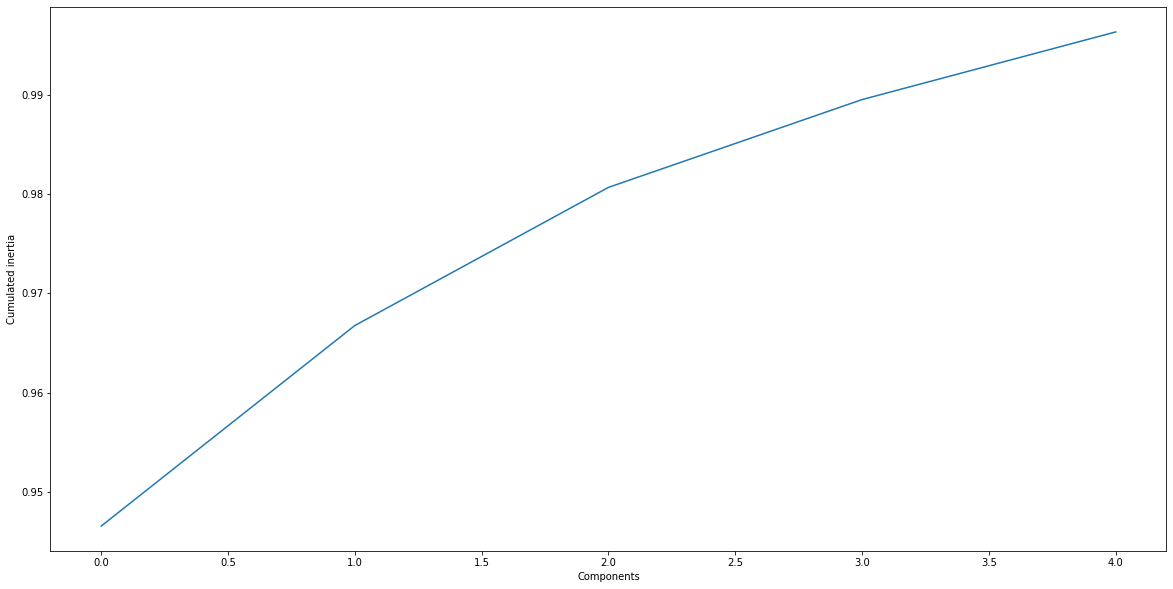

In [75]:
plot_inertia(pca_with_args_normed)

In [76]:
get_n_components(pca_with_args_normed)

5

In [85]:
import pprint
pprint.pprint(most_important(pca_with_args_normed))

['Volume',
 'delta',
 '# of Trades',
 'barClose - currentLow',
 'barClose - currentLow']


### Not-normed

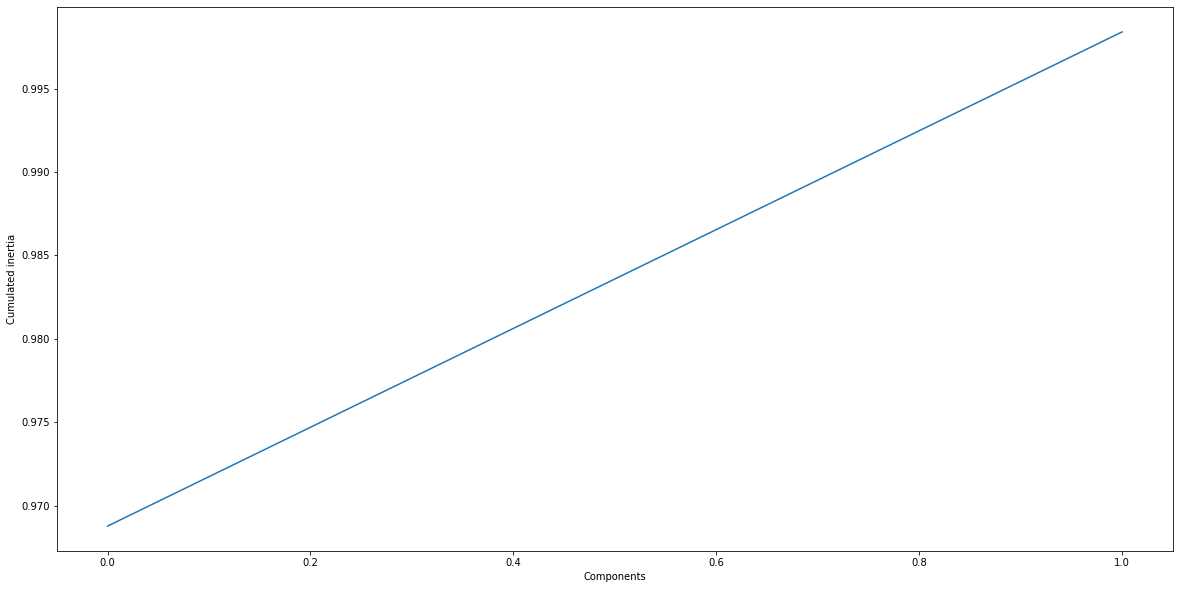

In [78]:
plot_inertia(pca_with_args)

In [79]:
get_n_components(pca_with_args)

2

In [83]:
print(most_important(pca_with_args))

['High', 'Volume']
